## NDWI = (Green − NIR)/(Green + NIR)

Data: Landsat

In [1]:
import ee
import geemap

In [2]:
Map = geemap.Map()

In [3]:
roi = ee.FeatureCollection('TIGER/2018/States').filter(
    ee.Filter.eq('NAME', 'Tennessee')
)
Map.addLayer(roi, {}, "TN")
Map.centerObject(roi, 7)

In [4]:
images = geemap.landsat_timeseries(
    roi=roi, start_year=2010, end_year=2020, start_date='01-01', end_date='12-31'
)

In [5]:
first = images.first()

vis_params = {'bands': ['NIR', 'Red', 'Green'], 'min': 0, 'max': 3000}

Map.addLayer(first, vis_params, 'First image')

In [6]:
ndwi_images = images.map(
    lambda img: img.normalizedDifference(['Green', 'NIR']).rename('ndwi')
)

ndwi_palette = [
    '#ece7f2',
    '#d0d1e6',
    '#a6bddb',
    '#74a9cf',
    '#3690c0',
    '#0570b0',
    '#045a8d',
    '#023858',
]

first_ndwi = ndwi_images.first()

Map.addLayer(first_ndwi, {'palette': ndwi_palette}, 'First NDWI')

In [7]:
water_images = ndwi_images.map(lambda img: img.gt(0).selfMask())

first_water = water_images.first()

Map.addLayer(first_water, {'palette': ['blue']}, 'First Water')

In [8]:
def cal_area(img):
    pixel_area = img.multiply(ee.Image.pixelArea()).divide(1e6)
    img_area = pixel_area.reduceRegion(
        **{
            'geometry': roi.geometry(),
            'reducer': ee.Reducer.sum(),
            'scale': 1000,
            'maxPixels': 1e12,
        }
    )
    return img.set({'water_area': img_area})

In [9]:
water_areas = water_images.map(cal_area)

In [10]:
water_stats = water_areas.aggregate_array('water_area').getInfo()
water_stats

[{'ndwi': 190.27880698529424},
 {'ndwi': 172.13400571200984},
 {'ndwi': 189.66535486250012},
 {'ndwi': 253.72756076372542},
 {'ndwi': 274.12814106151956},
 {'ndwi': 225.45507405686277},
 {'ndwi': 259.3425265877451},
 {'ndwi': 240.90428171764697},
 {'ndwi': 253.25578647352938},
 {'ndwi': 285.1482845705882},
 {'ndwi': 269.88373494436274}]

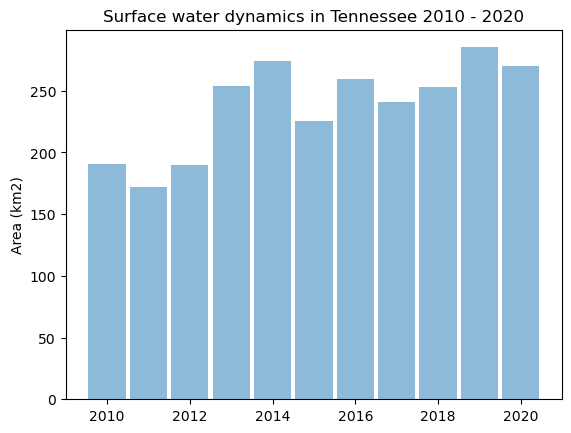

In [11]:
import matplotlib.pyplot as plt

x = list(range(2010, 2021))
y = [item.get('ndwi') for item in water_stats]

plt.bar(x, y, width=0.9, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
plt.ylabel('Area (km2)')
plt.title('Surface water dynamics in Tennessee 2010 - 2020')

plt.show()

In [12]:
Map.addLayerControl()
Map

Map(center=[35.8579904338385, -86.35074162079951], controls=(WidgetControl(options=['position', 'transparent_b…